In [18]:
!apt-get install dssp
!pip install prody

import os
import prody as pr
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def distancematrix(AtomMap):
  """Generate a distance matrix from the AtomMap"""    
  coordinates = []

  for pi in AtomMap.select('calpha').getResnums():

    # Check for existance of sidechain, if exists, take center of mass of sidechain, if not, take center of mass of calpha (=calpha)
    if not AtomMap.select('sc and resnum %d' % pi):
      coordinates.append(pr.calcCenter(AtomMap.select('calpha and resnum %d' % pi)))
    else:
      coordinates.append(pr.calcCenter(AtomMap.select('sc and resnum %d' % pi)))

  coordinates = np.array(coordinates)
  distancematrix = pr.buildDistMatrix(coordinates, coordinates)
  return distancematrix

# Library with absolute surface areas: doi:10.1371/journal.pone.0080635
TotAAArea={"ALA": 129.0,
  "ARG": 274.0,
  "ASN": 195.0,
  "ASP": 193.0,
  "CYS": 167.0,
  "GLU": 223.0,
  "GLN": 225.0,
  "GLY": 104.0,
  "HIS": 224.0,
  "ILE": 197.0,
  "LEU": 201.0,
  "LYS": 236.0,
  "MET": 224.0,
  "PHE": 240.0,
  "PRO": 159.0,
  "SER": 155.0,
  "THR": 172.0,
  "TRP": 285.0,
  "TYR": 263.0,
  "VAL": 174.0 }

# Find the distance parameters for user-defined pairs
def findResPair(pdbA, pdbB, resnlist):
    
  # Get entries from PDB
  p = pr.parsePDB(pdbB)
  q = pr.parsePDB(pdbA)

  # Execute DSSP calculation for downloaded PDB files
  pr.execDSSP(os.path.join(os.getcwd(), pdbB + ".pdb.gz"))
  pr.execDSSP(os.path.join(os.getcwd(), pdbA + ".pdb.gz"))
  tp = pr.parseDSSP(os.path.join(os.getcwd(), pdbB + ".dssp"), p)
  tq = pr.parseDSSP(os.path.join(os.getcwd(), pdbA + ".dssp"), q)
  
  # Align sequences
  pm = pr.matchAlign(tp, tq, tarsel = 'protein')[1]
  qm = pr.matchAlign(tp, tq, tarsel = 'protein')[2]

  # Generate distance matrices
  confA = distancematrix(qm)
  confB = distancematrix(pm)
  diff = confA - confB

  # Get the solutions that are non zero and define an outputlist
  solution = np.transpose(np.nonzero(diff))
  
  solutionResidues = []

  #Search for provided residue pairs and append them to the outputlist
  for resni, resnj in resnlist:

    for i, j in solution:

      acc_qm_i = round(100 * (qm.select('calpha').getData('dssp_acc')[i] / TotAAArea[qm.select('calpha').getResnames()[0]]))
      acc_qm_j = round(100 * (qm.select('calpha').getData('dssp_acc')[j] / TotAAArea[qm.select('calpha').getResnames()[0]]))
      acc_pm_i = round(100 * (pm.select('calpha').getData('dssp_acc')[i] / TotAAArea[pm.select('calpha').getResnames()[0]]))
      acc_pm_j = round(100 * (pm.select('calpha').getData('dssp_acc')[j] / TotAAArea[pm.select('calpha').getResnames()[0]]))
      
      if pm.select('calpha').getResnums()[i] == resni and pm.select('calpha').getResnums()[j] == resnj:

        residue1 = "%s%d" % (pm.select('calpha').getResnames()[i], pm.select('calpha').getResnums()[i])
        residue2 = "%s%d" % (qm.select('calpha').getResnames()[j], qm.select('calpha').getResnums()[j])
        
        values = []
        values.append("%s with %s" % (residue1, residue2))
        values.append(diff[i, j])
        values.append(confA[i, j])
        values.append(confB[i, j])
        values.append(acc_pm_i)
        values.append(acc_pm_j)
        values.append(acc_qm_i)
        values.append(acc_qm_j)

        solutionResidues.append(tuple(values))
  
  columns = ("residue pair", "distance change", "distance confA", "distance confB", "surfAccRes1ConfB", "surfAccRes2ConfB", "surfAccRes1ConfA", "surfAccRes2ConfA")
  print("%20s %16s %16s %16s %16s %16s %16s %16s" % columns)
  for values in solutionResidues:
    print("%20s %16.2f %16.2f %16.2f %16.2f %16.2f %16.2f %16.2f" % values)

# Find new pairs based on user-defined parameters
def findResPairs(pdbA, pdbB, distanceChange=7, distanceAbsoluteUpper=80, distanceAbsoluteLower=40, acc_threshold=40):    
  
  # Get entries from PDB
  p = pr.parsePDB(pdbB)
  q = pr.parsePDB(pdbA)
  
  # Execute DSSP calculation for downloaded PDB files
  pr.execDSSP(os.path.join(os.getcwd(), pdbB + '.pdb.gz'))
  pr.execDSSP(os.path.join(os.getcwd(), pdbA + '.pdb.gz'))
  tp = pr.parseDSSP(os.path.join(os.getcwd(), pdbB +'.dssp'), p)
  tq = pr.parseDSSP(os.path.join(os.getcwd(), pdbA +'.dssp'), q)

  # Align sequences
  pm = pr.matchAlign(tp, tq, tarsel='protein')[1]
  qm = pr.matchAlign(tp, tq, tarsel='protein')[2]

  # Generate distance matrices
  confA = distancematrix(qm)
  confB = distancematrix(pm)
  diff = confA - confB
  resid = diff.copy()

  # Apply distance constraints
  resid[confA < distanceAbsoluteLower] = 0
  resid[confA > distanceAbsoluteUpper] = 0 
  resid[confB < distanceAbsoluteLower] = 0 
  resid[confB > distanceAbsoluteUpper] = 0
  resid_abs = resid.copy()
    
  resid[np.abs(diff) < distanceChange] = 0
  resid_dist = resid.copy()
  
  # Get the solutions that are non zero and define an outputlist
  solution = np.transpose(np.nonzero(np.triu(resid)))
  
  solutionResidues = []

  # Generate a PyMol file for easy visualization
  output = open("Output_" + pdbA + ".pml", "w")
  output.write('fetch ' + pdbA + '\n hide everything \n show cartoon,' + pdbA + '\n color green,' + pdbA + '\n')

  # loop over pairs that were left after distance constraints, if within DSSP constraits append to outputlist and PyMol file
  for i, j in solution:
    acc_qm_i = round(100 * (qm.select('calpha').getData('dssp_acc')[i] / TotAAArea[qm.select('calpha').getResnames()[0]]))
    acc_qm_j = round(100 * (qm.select('calpha').getData('dssp_acc')[j] / TotAAArea[qm.select('calpha').getResnames()[0]]))
    acc_pm_i = round(100 * (pm.select('calpha').getData('dssp_acc')[i] / TotAAArea[pm.select('calpha').getResnames()[0]]))
    acc_pm_j = round(100 * (pm.select('calpha').getData('dssp_acc')[j] / TotAAArea[pm.select('calpha').getResnames()[0]]))

    if acc_pm_i > acc_threshold and acc_qm_i > acc_threshold and acc_pm_j > acc_threshold and acc_qm_j > acc_threshold:
            
      residue1 = "%s%d" % (pm.select('calpha').getResnames()[i], pm.select('calpha').getResnums()[i])
      residue2 = "%s%d" % (qm.select('calpha').getResnames()[j], qm.select('calpha').getResnums()[j])
      
      values = []
      values.append("%s with %s" % (residue1, residue2))
      values.append(diff[i, j])
      values.append(confA[i, j])
      values.append(confB[i, j])
      values.append(acc_pm_i)
      values.append(acc_pm_j)
      values.append(acc_qm_i)
      values.append(acc_qm_j)

      solutionResidues.append(tuple(values))

      if resid[i,j] < 0:
        print(np.min(resid))
        output.write('create pairs_neg, '+pdbA+' and (resi '+str(pm.select('calpha').getResnums()[i])+' or resi '+str(pm.select('calpha').getResnums()[j])+') and name ca, 0, -1\n')
      if resid[i,j] > 0:
        output.write('create pairs_pos, '+pdbA+' and (resi '+str(pm.select('calpha').getResnums()[i])+' or resi '+str(pm.select('calpha').getResnums()[j])+') and name ca, 0, -1\n')        
    else:
      resid[i,j] = 0
      resid[j,i] = 0


  #Close PyMol file
  output.write('show spheres, pairs_pos'+'\n color blue, pairs_pos'+'\n show spheres, pairs_neg'+'\n color red, pairs_neg'+'\n')
  output.close()

  #print and visualize the solution pairs
  print('%d pairs found!' % len(solutionResidues))

  figure=plt.figure(figsize=(16,6))
  f, axarr = plt.subplots(2,3,sharey='row', sharex='col')
  f.subplots_adjust(wspace=0.05)
  f.subplots_adjust(hspace=0.08)
  plt.rcParams['svg.fonttype'] = 'none'
  plt.rcParams['pdf.fonttype'] = 42
  plt.rcParams['ps.fonttype'] = 42
  plt.rcParams['figure.dpi']= 300
  f.set_figheight(15)
  f.set_figwidth(20)

  axarr[0,0].set_title(pdbA)
  axarr[0,0].imshow(confA,cmap='Blues')
  axarr[0,1].set_title(pdbB)
  axarr[0,1].imshow(confB,cmap='Blues')
  axarr[0,2].set_title('Difference')
  axarr[0,2].imshow(diff, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), cmap='RdBu')
  
  axarr[1,0].set_title('Absolute distance constraints')
  axarr[1,0].imshow(resid_abs, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), cmap='RdBu')
  axarr[1,1].set_title('Distance shift constraints')
  axarr[1,1].imshow(resid_dist, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), cmap='RdBu')
  axarr[1,2].set_title('Picked Pairs')
  axarr[1,2].imshow(resid, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), cmap='RdBu')
  
  print(np.min(resid))
  
  for j in range(2):
    axarr[j,0].set_ylabel('residue number')
    for i in range(3):    
      axarr[1,i].set_xlabel('residue number')
      axarr[j,i].set_xticks(np.arange(pm[0].getResnum()-pm[0].getResnum(), pm[-1].getResnum()-pm[0].getResnum(), step=40))
      axarr[j,i].set_yticks(np.arange(pm[0].getResnum()-pm[0].getResnum(), pm[-1].getResnum()-pm[0].getResnum(), step=40))    
      axarr[j,i].set_xticklabels(np.arange(pm[0].getResnum(), pm[-1].getResnum(), step=40))
      axarr[j,i].set_yticklabels(np.arange(pm[0].getResnum(), pm[-1].getResnum(), step=40))
  f.savefig('output'+pdbA+'.pdf', format='pdf')

  columns = ("residue pair", "distance change", "distance confA", "distance confB", "surfAccRes1ConfB", "surfAccRes2ConfB", "surfAccRes1ConfA", "surfAccRes2ConfA")
  print("%20s %16s %16s %16s %16s %16s %16s %16s" % columns)
  for values in solutionResidues:
    print("%20s %16.2f %16.2f %16.2f %16.2f %16.2f %16.2f %16.2f" % values)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
dssp is already the newest version (3.0.0-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


@> PDB file is found in working directory (3l6h.pdb.gz).
@> 2145 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> PDB file is found in working directory (3l6g.pdb.gz).
@> 2304 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Checking AtomGroup 3l6h: 1 chains are identified
@> Checking AtomGroup 3l6g: 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 3l6h (len=254) and Chain A from 3l6g (len=256):
@> 	Match: 254 residues match with 100% sequence identity and 99% overlap.
@> Alignment is based on 1995 atoms matching 'protein'.
@> Before alignment RMSD: 33.18
@> After alignment  RMSD: 3.65
@> Checking AtomGroup 3l6h: 1 chains are identified
@> Checking AtomGroup 3l6g: 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 3l6h (len=254) and Chain A from 3l6g (len=256):
@> 	Match: 254 residues match with 100% sequence identity and 99% overlap.
@> Alignment 

-8.442578745134476
9 pairs found!
-8.442578745134476
        residue pair  distance change   distance confA   distance confB surfAccRes1ConfB surfAccRes2ConfB surfAccRes1ConfA surfAccRes2ConfA
  ASP320 with ASN447             8.75            58.83            50.08            92.00            73.00           106.00            74.00
  ASP320 with LYS453             9.41            67.28            57.86            92.00            91.00           106.00            89.00
  GLN369 with ASN426             8.43            52.22            43.79            69.00            71.00            66.00            73.00
  GLN369 with ASP450             8.32            53.18            44.86            69.00            77.00            66.00            78.00
  GLN369 with LYS453            11.42            54.47            43.05            69.00            91.00            66.00            89.00
  LYS391 with ASN426             8.72            51.28            42.55            98.00            71.00  

<Figure size 1152x432 with 0 Axes>

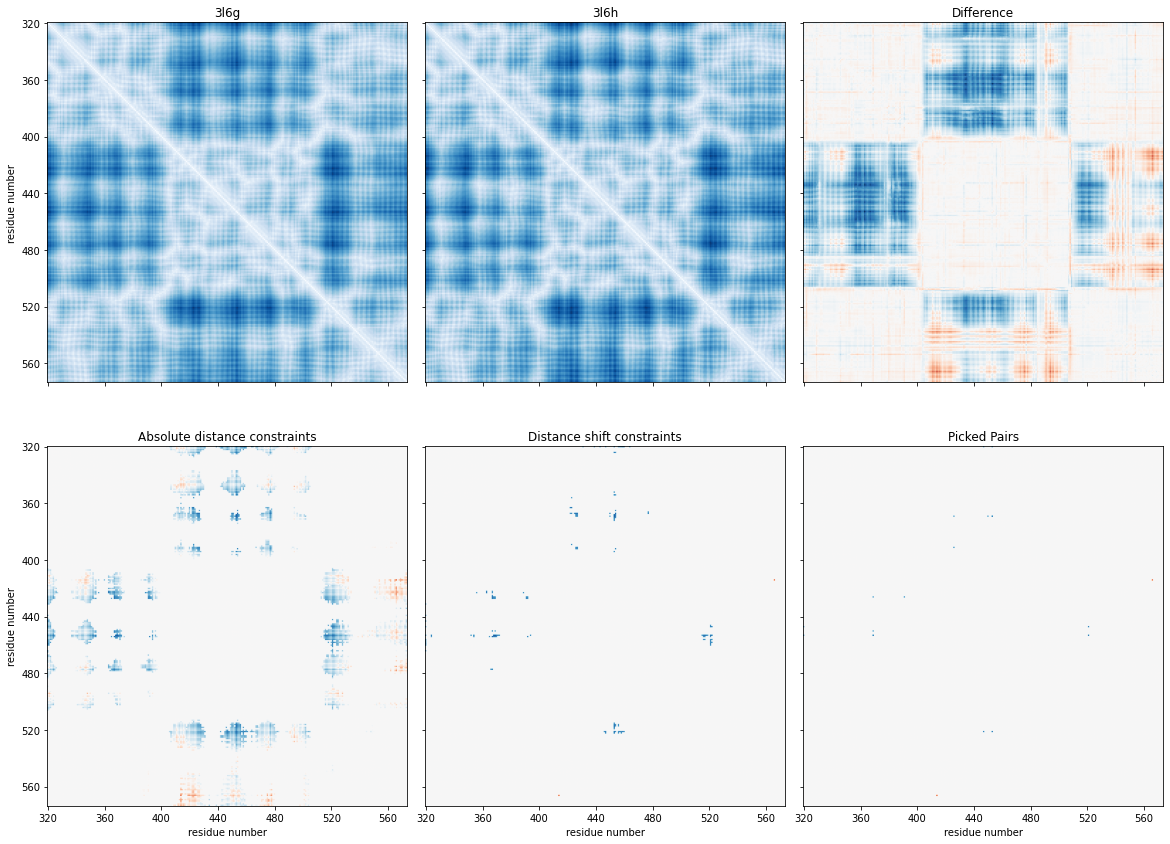

In [19]:
#Example of use: findResPairs('3l6g','3l6h',distanceChange=7,distanceAbsoluteUpper=80,distanceAbsoluteLower=40,acc_threshold=40)

#Example OpuAC in open and closed conformation with minimum distance change of 8A and accessibility threshold of 125
findResPairs('3l6g', '3l6h', distanceChange=8, acc_threshold=60)